# Introduction to NLP Fundamentals in TensorFlow

NLP has the goal of deriving information of natural language (could be sequences or speech).

Another terms for NLP problems is sequences to sequences (seq2seq).

## Check for gpu

In [ ]:
!nvidia-smi -L

GPU 0: Tesla K80 (UUID: GPU-e340fa2c-52ff-839a-b08b-224490e201ff)


In [ ]:
## Get helper functions
!wget https://raw.githubusercontent.com/BaoLocPham/Tensorflow_Deep_Learning/main/Utils/helper_functions.py

--2021-08-16 13:43:49--  https://raw.githubusercontent.com/BaoLocPham/Tensorflow_Deep_Learning/main/Utils/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11240 (11K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.98K  --.-KB/s    in 0s      

2021-08-16 13:43:49 (85.1 MB/s) - ‘helper_functions.py’ saved [11240/11240]



In [ ]:
# import series of helper functions for the notebook
from helper_functions import unzip_data, create_tensorboard_callback, plot_loss_curves, compare_historys

## Get text dataset

The dataset we're goint to be using is Kaggle introduction to NLP dataset (text samples of tweets label as disaster or not disaster).

See the original source: https://www.kaggle.com/c/nlp-getting-started

In [ ]:
!wget https://storage.googleapis.com/ztm_tf_course/nlp_getting_started.zip

# unzip data
unzip_data("nlp_getting_started.zip")

--2021-08-16 13:43:57--  https://storage.googleapis.com/ztm_tf_course/nlp_getting_started.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.140.128, 108.177.15.128, 173.194.76.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.140.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 607343 (593K) [application/zip]
Saving to: ‘nlp_getting_started.zip’

nlp_getting_started 100%[===================>] 593.11K  --.-KB/s    in 0.006s  

2021-08-16 13:43:58 (103 MB/s) - ‘nlp_getting_started.zip’ saved [607343/607343]



## Become one with the data

Visualize, Visualize, Visualize

In [ ]:
import pandas as pd

test_df = pd.read_csv("test.csv")
train_df = pd.read_csv("train.csv")
sample_submit_df = pd.read_csv("sample_submission.csv")

In [ ]:
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [ ]:
train_df.tail()

,id,keyword,location,text,target
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1
7612,10873,NaN,NaN,The Latest: More Homes Razed by Northern Calif...,1


In [ ]:
train_df['text'].nunique()

7503

In [ ]:
## shuffle training dataframe
train_df_shuffled = train_df.sample(frac=1, random_state=42)
train_df_shuffled.head()

,id,keyword,location,text,target
2644,3796,destruction,NaN,So you have a new weapon that can cause un-ima...,1
2227,3185,deluge,NaN,The f$&amp;@ing things I do for #GISHWHES Just...,0
5448,7769,police,UK,DT @georgegalloway: RT @Galloway4Mayor: ÛÏThe...,1
132,191,aftershock,NaN,Aftershock back to school kick off was great. ...,0
6845,9810,trauma,"Montgomery County, MD",in response to trauma Children of Addicts deve...,0


In [ ]:
test_df.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [ ]:
train_df["target"].value_counts()

0    4342
1    3271
Name: target, dtype: int64

In [ ]:
# how many total samples
len(train_df), len(test_df)

(7613, 3263)

In [ ]:
# Let's visualize some training examples
import random 

random_index = random.randint(0, len(train_df)-5)
for row in train_df_shuffled[["text","target"]][random_index:random_index+5].itertuples():
  _, text, target = row
  print(f"Target: {target}", "real disaster" if target == 1 else "not real disaster")
  print(f"Text: {text}")
  print("--\n")

Target: 0 not real disaster
Text: http://t.co/3nUiH6pkUi #shoes Asics GT-II Super Red 2.0 11 Ronnie Fieg Kith Red White 3M x gel grey volcano 2 http://t.co/2ufCC6gH3m
--

Target: 1 real disaster
Text: @SoonerMagic_ I mean I'm a fan but I don't need a girl sounding off like a damn siren
--

Target: 0 not real disaster
Text: INFANTRY Mens Lume Dial Army Analog Quartz Wrist Watch Sport Blue Nylon Fabric  - Full reaÛ_ http://t.co/hEP9k0XgHb http://t.co/80EBvglmrA
--

Target: 0 not real disaster
Text: *NEW* Snap On Tools Black baseball Hat/Cap Silver/Gray Embroidered S Logo Flames - Full reÛ_ http://t.co/mO7DbBdFVR http://t.co/0ScNWe8XbV
--

Target: 1 real disaster
Text: @BrittanyPetko breaking news tonight kids were rescued from play room after a week with no food or water do to parents sex life haha
--



## Split data into training and validation set

In [ ]:
from sklearn.model_selection import train_test_split

# use train_test_split to split train_df to training and validation sets
train_sentences, val_sentences, train_labels, val_labels = train_test_split(train_df_shuffled["text"].to_numpy(),
                                                                            train_df_shuffled["target"].to_numpy(),
                                                                            test_size=0.1, # use 10% of training data for validation
                                                                            random_state=42)

In [ ]:
# check the lengths
len(train_sentences), len(train_labels), len(val_sentences), len(val_labels)

(6851, 6851, 762, 762)

In [ ]:
# check the first 10 samples
train_sentences[:10]

array(['@mogacola @zamtriossu i screamed after hitting tweet',
       'Imagine getting flattened by Kurt Zouma',
       '@Gurmeetramrahim #MSGDoing111WelfareWorks Green S welfare force ke appx 65000 members har time disaster victim ki help ke liye tyar hai....',
       "@shakjn @C7 @Magnums im shaking in fear he's gonna hack the planet",
       'Somehow find you and I collide http://t.co/Ee8RpOahPk',
       '@EvaHanderek @MarleyKnysh great times until the bus driver held us hostage in the mall parking lot lmfao',
       'destroy the free fandom honestly',
       'Weapons stolen from National Guard Armory in New Albany still missing #Gunsense http://t.co/lKNU8902JE',
       '@wfaaweather Pete when will the heat wave pass? Is it really going to be mid month? Frisco Boy Scouts have a canoe trip in Okla.',
       'Patient-reported outcomes in long-term survivors of metastatic colorectal cancer - British Journal of Surgery http://t.co/5Yl4DC1Tqt'],
      dtype=object)

## Convert text into numbers

When dealing with a text problem, one of the first things you'll have to do before you can build a model is to convert your text to number.

There are few ways to do this:
* Tokenziation - direct mapping of token (a token could be a word or a character) to number.
* Embedding - create matrix of feature vector for each token. (the size of the feature vector can be defined and this embedding can be learn).

### Text vectorization (Tokenization)

In [ ]:
train_sentences[:5]

array(['@mogacola @zamtriossu i screamed after hitting tweet',
       'Imagine getting flattened by Kurt Zouma',
       '@Gurmeetramrahim #MSGDoing111WelfareWorks Green S welfare force ke appx 65000 members har time disaster victim ki help ke liye tyar hai....',
       "@shakjn @C7 @Magnums im shaking in fear he's gonna hack the planet",
       'Somehow find you and I collide http://t.co/Ee8RpOahPk'],
      dtype=object)

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

In [ ]:
# Use the default TextVectorization parameters
text_vectorizer = TextVectorization(max_tokens=None, # How many words in vocabulary (automatically add <OOV>)
                                    standardize="lower_and_strip_punctuation",
                                    split="whitespace",
                                    ngrams=None, # create groups of n-words
                                    output_mode="int", # how to map tokens to number
                                    output_sequence_length=None, # how long you want sequences to be
                                    pad_to_max_tokens=True
                                    )

In [ ]:
# Find the average number of tokens (words) in the training tweets
round(sum([len(i.split()) for i in train_sentences])/len(train_sentences))

15

In [ ]:
a = " ".join(train_sentences)
aa = set(a.split(" "))
len(aa) # count number of unique words in train_setences

29642

In [ ]:
# Set up text vectorization variables
max_vocab_length = 10000 # number of words in vocabulary
max_length =  15 # max length our setences will be (e.g how many words from a tweet does our model sees?)

text_vectorizer = TextVectorization(max_tokens=max_vocab_length,
                                    output_mode="int",
                                    output_sequence_length=max_length)

In [ ]:
# Fit the text_vectorizer to the training text
text_vectorizer.adapt(train_sentences)

In [ ]:
# Create a sample setences and tokenize it
sample_sentence = "There's a flood in my street!"
text_vectorizer([sample_sentence])

<tf.Tensor: shape=(1, 15), dtype=int64, numpy=
array([[264,   3, 232,   4,  13, 698,   0,   0,   0,   0,   0,   0,   0,
          0,   0]])>

In [ ]:
# Choose a random sentence from the training data and tokenize it
random_sentence = random.choice(train_sentences)
print(f"Origin text:\n {random_sentence}\
          \n\nVectorize version:")
text_vectorizer([random_sentence])


Origin text:
 #ModiMinistry Madhya Pradesh Train Derailment: Village Youth Saved Many Lives http://t.co/YvMpHd0z9X          

Vectorize version:


<tf.Tensor: shape=(1, 15), dtype=int64, numpy=
array([[3613,  941,  928,  119,  306,  830,  720,  670,  123,  394,    1,
           0,    0,    0,    0]])>

In [ ]:
# get the unique words in the vocabulary
words_in_vocab = text_vectorizer.get_vocabulary()
top_5_words = words_in_vocab[:5] # most common words
bottom_5_words = words_in_vocab[-5:] # least common words
print(f"Number of words in vocab: {len(words_in_vocab)}")
print(f"5 most common words: {top_5_words}")
print(f"5 least common words: {bottom_5_words}")

Number of words in vocab: 10000
5 most common words: ['', '[UNK]', 'the', 'a', 'in']
5 least common words: ['pages', 'paeds', 'pads', 'padres', 'paddytomlinson1']


### Creating an Embedding using an Embedding Layer

To make our embeddings, we're going to use TensorFlow's embedding layer: https://www.tensorflow.org/api_docs/python/tf/keras/layers/Embedding

The parameter we care most about for our embedding layer:
* `input_dim` = the size of the vocabulary
* `output_dim` = the size of the output embedding vector
* `input_length` = length of the sentence being passed to the embedding layer

In [ ]:
from tensorflow.keras import layers

embedding = layers.Embedding(input_dim=max_vocab_length, # set input shape
                             output_dim=128, # output shape
                             embeddings_initializer="uniform",
                             input_length=max_length # how long is each input
                             )

embedding

In [ ]:
# Get a random sentence in the training set 
random_sentence = random.choice(train_sentences)
print(f"Original text: \n{random_sentence}\
\n\nEmbedded version:")
# Embed the ramdon sentence (turn it into dense vector of fixed size)
sample_vectorized = text_vectorizer([random_sentence])
sample_embedded = embedding(sample_vectorized)
sample_embedded

Original text: 
If you have a son or a daughter would you like to see them going to a war with Iran and come back in a body bag? Let the #Republicans know

Embedded version:


<tf.Tensor: shape=(1, 15, 128), dtype=float32, numpy=
array([[[ 0.01851043, -0.00966452,  0.01838999, ...,  0.01760156,
         -0.02783248, -0.00746161],
        [-0.02389767,  0.02231025,  0.03622473, ...,  0.0162524 ,
         -0.0298705 , -0.03385837],
        [-0.02385774,  0.01881075,  0.02031971, ..., -0.03389629,
          0.00290325,  0.03122694],
        ...,
        [ 0.02352694, -0.01865736,  0.01880741, ..., -0.02511199,
          0.04628481, -0.03687084],
        [-0.03653019,  0.02217865, -0.00535245, ..., -0.03748636,
          0.02911862, -0.03644769],
        [ 0.01608015,  0.04328299,  0.02940502, ...,  0.02498314,
         -0.02447721, -0.01921989]]], dtype=float32)>

In [ ]:
sample_embedded[0][0], sample_embedded[0][0].shape, random_sentence

(<tf.Tensor: shape=(128,), dtype=float32, numpy=
 array([ 0.01851043, -0.00966452,  0.01838999,  0.01476422,  0.02803269,
         0.03300652,  0.01386446,  0.03980101,  0.00336692,  0.02812319,
        -0.02165053, -0.03231317,  0.01317621,  0.00993408,  0.04969073,
         0.02728287,  0.00751296,  0.00348948, -0.04145392,  0.00664186,
        -0.01240242, -0.02088461, -0.01407208,  0.00815877,  0.02656462,
        -0.02954282,  0.02640254, -0.00185958,  0.03036875, -0.0385746 ,
         0.00154553, -0.04020209,  0.01284124, -0.01590704, -0.02270491,
         0.00604848,  0.04615805,  0.00670002, -0.03691768, -0.00304005,
         0.00495056, -0.01259802, -0.04701346,  0.01412454, -0.01498545,
         0.02206102, -0.02455278, -0.02717798, -0.0018649 , -0.00262924,
         0.03858186, -0.01651026,  0.02828232,  0.04733297, -0.01384313,
         0.02695889, -0.04766952, -0.03490256, -0.02039587, -0.02392083,
        -0.04285034, -0.020233  ,  0.03112866, -0.01117919,  0.03130131,
  

## Modelling a text dataset (running a series of experiments)

Now we've got way to turn our text sequences into numbers, it's time to start building a series of modelling experiments.

We'll start with a baseline and move on from there.

* Model 0: Naive Bayes (baseline), this is from sklearn ML map: https://scikit-learn.org/stable/tutorial/machine_learning_map/index.html
* Model 1: Feed-forward neural network (dense model).
* Model 2: LSTM model (RNN).
* Model 3: GRU model (RNN).
* Model 4: Bidirectional-LSTM model (RNN).
* Model 5: 1D Convolutional Neural Network (CNN).
* Model 6: TensorFlow Hun Pretrained Feature Extractor (using Transfer learning for NLP).
* Model 7: Same as model 6 with 10% of training data.

How are we going to approach all of these?

Use the standard steps in modelling with tensorflow:

* Create a model.
* Build a model.
* Fit a model.
* Evaluate a model.

### Model 0: Getting a baseline

As with all machine learning modelling experiments, it's important to create a baseliine model so you've got a benchmark for future experiments to build a model upon.

To create our baseline, we'll use Sklearn's Multinomial Naive Bayes using the TF-IDF formular to convert our words to number.

>🔑**Note:** It's common practice to use non-DL algorithm as a baseline because of their speed and then later use DL to see if you can improve upon them.

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

# Create tokenization and modelling pipeline
model_0 = Pipeline([
                    ("tfidf", TfidfVectorizer()), # Convert words to numbers using tfidf
                    ("clf", MultinomialNB()) # model the text
])

# Fit the pipeline to the training data
model_0.fit(train_sentences, train_labels)

Pipeline(memory=None,
         steps=[('tfidf',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, use_idf=True,
                                 vocabulary=None)),
                ('clf',
                 MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))],
         verbose=False)

In [ ]:
# Evaluate our baseline model
baseline_score = model_0.score(val_sentences, val_labels)
print(f"Our baseline model achieves an accuracy of: {baseline_score*100:.2f}%")

Our baseline model achieves an accuracy of: 79.27%


In [ ]:
train_df.target.value_counts() 

0    4342
1    3271
Name: target, dtype: int64

In [ ]:
# Make predictions
baseline_preds = model_0.predict(val_sentences)
baseline_preds[:10]

array([1, 1, 1, 0, 0, 1, 1, 1, 1, 0])

In [ ]:
from sklearn.metrics import classification_report

# Evaluate metrics
y_true = val_labels
y_pred = model_0.predict(val_sentences)

baseline_report = classification_report(y_true=y_true, y_pred=y_pred)
print(baseline_report)

              precision    recall  f1-score   support

           0       0.75      0.93      0.83       414
           1       0.89      0.63      0.73       348

    accuracy                           0.79       762
   macro avg       0.82      0.78      0.78       762
weighted avg       0.81      0.79      0.79       762



### Creating an evaluation function for our model experiments

We could evaluate all of our model's prediction with different metrics every time, however, this will be cumbersome and could easily fixed with a function.


In [ ]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def calculate_results(y_true, y_pred):
  """
  Calculates model accuracy, precision, recall and f1 score of a binary classification
  """
  # Calculate model accuracy
  model_accuracy = accuracy_score(y_true, y_pred)*100
  # Calculate model precision, recall and f1-score using "weighted" average
  model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")
  model_results = {
      "accuracy":model_accuracy,
      "precision":model_precision,
      "recall":model_recall,
      "f1":model_f1
  }
  return model_results

In [ ]:
# Evaluate metrics
y_true = val_labels
y_pred = model_0.predict(val_sentences)

# Get baseline results
baseline_results = calculate_results(y_true=y_true,
                                     y_pred=y_pred)
baseline_results

{'accuracy': 79.26509186351706,
 'f1': 0.7862189758049549,
 'precision': 0.8111390004213173,
 'recall': 0.7926509186351706}

### Model 1: Feed-forward neural network (dense model).

In [ ]:
# Create a tensorboard callback
from helper_functions import create_tensorboard_callback

save_dir = "model_logs"

In [ ]:
# from pathlib import Path
# import shutil

# dirpath = Path('model_logs') 
# if dirpath.exists() and dirpath.is_dir():
#     shutil.rmtree(dirpath)

In [ ]:
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from tensorflow.keras.layers import Embedding

# Set up text vectorization variables
max_vocab_length = 10000 # number of words in vocabulary
max_length =  15 # max length our setences will be (e.g how many words from a tweet does our model sees?)

text_vectorizer = TextVectorization(max_tokens=max_vocab_length,
                                    output_mode="int",
                                    output_sequence_length=max_length)

# fit the text_vectorizer for the training text
text_vectorizer.adapt(train_sentences)

embedding = Embedding(input_dim=max_vocab_length, # set input shape
                             output_dim=128, # output shape
                             embeddings_initializer="uniform",
                             input_length=max_length # how long is each input
                             )

In [ ]:

# Get a random sentence from training set
random_sentence = random.choice(train_sentences)
print(f"Original text:\n{random_sentence}\
      \n\nEmbedded version:")

# Embed the random sentence (turn it into numerical representation)
sample_embed = embedding(text_vectorizer([random_sentence]))
sample_embed

Original text:
@ArianaGrande @justinbieber All the loves be screaming at this one ??????      

Embedded version:


<tf.Tensor: shape=(1, 15, 128), dtype=float32, numpy=
array([[[-2.6298070e-02,  1.0526933e-02, -4.4802785e-02, ...,
         -3.2632113e-02,  7.2503313e-03,  2.8236043e-02],
        [-4.4330586e-02,  1.7117709e-05, -2.0491863e-02, ...,
         -3.7896048e-02,  4.0968884e-02,  4.9924981e-02],
        [-3.8759984e-02, -4.0039532e-03, -2.8994251e-02, ...,
          2.1078292e-02,  2.9366765e-02, -4.3194342e-02],
        ...,
        [-3.8000718e-03, -3.7332702e-02,  4.9609374e-02, ...,
         -4.3024600e-02,  1.4334444e-02,  3.7791375e-02],
        [-3.8000718e-03, -3.7332702e-02,  4.9609374e-02, ...,
         -4.3024600e-02,  1.4334444e-02,  3.7791375e-02],
        [-3.8000718e-03, -3.7332702e-02,  4.9609374e-02, ...,
         -4.3024600e-02,  1.4334444e-02,  3.7791375e-02]]], dtype=float32)>

In [ ]:
# Build model with the Functional API
from tensorflow.keras import layers
tf.random.set_seed(42)
inputs = layers.Input(shape=(1,), dtype=tf.string) # inputs are 1-dimensional strings

# transfer input into embeddings
x = text_vectorizer(inputs)
x = embedding(x)

outputs = layers.Dense(1, activation="sigmoid")(x)

model_1 = tf.keras.Model(inputs, outputs, name="model_1_dense")

In [ ]:
model_1.summary()

Model: "model_1_dense"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
text_vectorization_2 (TextVe (None, 15)                0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 15, 128)           1280000   
_________________________________________________________________
dense (Dense)                (None, 15, 1)             129       
Total params: 1,280,129
Trainable params: 1,280,129
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Compile the model
model_1.compile(
    loss="binary_crossentropy",
    optimizer=tf.keras.optimizers.Adam(),
    metrics=["accuracy"]
)

In [ ]:
# Fit the model
model_1_history = model_1.fit(x=train_sentences,
                              y=train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(dir_name=save_dir,
                                                                     experiment_name="model_1_dense")])

Saving TensorBoard log files to: model_logs/model_1_dense/20210816-021011
Epoch 1/5
215/215 [==============================] - 7s 17ms/step - loss: 0.6492 - accuracy: 0.6398 - val_loss: 0.6306 - val_accuracy: 0.6501
Epoch 2/5
215/215 [==============================] - 3s 14ms/step - loss: 0.5969 - accuracy: 0.6900 - val_loss: 0.6228 - val_accuracy: 0.6465
Epoch 3/5
215/215 [==============================] - 3s 14ms/step - loss: 0.5766 - accuracy: 0.6922 - val_loss: 0.6275 - val_accuracy: 0.6471
Epoch 4/5
215/215 [==============================] - 3s 14ms/step - loss: 0.5684 - accuracy: 0.6915 - val_loss: 0.6289 - val_accuracy: 0.6505
Epoch 5/5
215/215 [==============================] - 3s 15ms/step - loss: 0.5632 - accuracy: 0.6924 - val_loss: 0.6318 - val_accuracy: 0.6455


In [ ]:
# Check the results
model_1.evaluate(val_sentences, val_labels)

24/24 [==============================] - 0s 3ms/step - loss: 0.6318 - accuracy: 0.6455


[0.6317808628082275, 0.6454943418502808]

In [ ]:
# Make some prediction
model_1_pred_probs = model_1.predict(val_sentences)
model_1_pred_probs.shape # predictions per token

(762, 15, 1)

>🔑**Note** Look at the output shape, we can see our model is predicting per token, not a whole sentence.

Let's try fixed the model

In [ ]:
# Build model with the Functional API
from tensorflow.keras import layers
tf.random.set_seed(42)
inputs = layers.Input(shape=(1,), dtype=tf.string, name="input_layer") # inputs are 1-dimensional strings

# transfer input into embeddings
x = text_vectorizer(inputs)
x = embedding(x)

# --->Fixed
# Condense the feature vector for each token to one vector
x = layers.GlobalAveragePooling1D(name="global_average_pool_1D")(x)

outputs = layers.Dense(1, activation="sigmoid", name="output_layer")(x)

model_1_fixed = tf.keras.Model(inputs, outputs, name="model_1_dense_fixed")

In [ ]:
model_1_fixed.summary()

Model: "model_1_dense_fixed"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 1)]               0         
_________________________________________________________________
text_vectorization_2 (TextVe (None, 15)                0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 15, 128)           1280000   
_________________________________________________________________
global_average_pool_1D (Glob (None, 128)               0         
_________________________________________________________________
output_layer (Dense)         (None, 1)                 129       
Total params: 1,280,129
Trainable params: 1,280,129
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Compile the model
model_1_fixed.compile(
    loss="binary_crossentropy",
    optimizer=tf.keras.optimizers.Adam(),
    metrics=["accuracy"]
)

In [ ]:
model_1_fixed_history = model_1_fixed.fit(x=train_sentences,
                              y=train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(dir_name=save_dir,
                                                                     experiment_name="model_1_dense_fixed")])

Saving TensorBoard log files to: model_logs/model_1_dense_fixed/20210816-021031
Epoch 1/5
215/215 [==============================] - 5s 18ms/step - loss: 0.4848 - accuracy: 0.8342 - val_loss: 0.4845 - val_accuracy: 0.7861
Epoch 2/5
215/215 [==============================] - 3s 15ms/step - loss: 0.3493 - accuracy: 0.8699 - val_loss: 0.4527 - val_accuracy: 0.7848
Epoch 3/5
215/215 [==============================] - 3s 15ms/step - loss: 0.2825 - accuracy: 0.8920 - val_loss: 0.4539 - val_accuracy: 0.7927
Epoch 4/5
215/215 [==============================] - 3s 15ms/step - loss: 0.2378 - accuracy: 0.9137 - val_loss: 0.4652 - val_accuracy: 0.7927
Epoch 5/5
215/215 [==============================] - 3s 15ms/step - loss: 0.2033 - accuracy: 0.9270 - val_loss: 0.4814 - val_accuracy: 0.7874


In [ ]:
# check the resulst
model_1_fixed.evaluate(x=val_sentences, y=val_labels)

24/24 [==============================] - 0s 3ms/step - loss: 0.4814 - accuracy: 0.7874


[0.48140469193458557, 0.787401556968689]

In [ ]:
# Make some prediction
model_1_pred_probs = model_1_fixed.predict(val_sentences)
model_1_pred_probs.shape 

(762, 1)

In [ ]:
model_1_pred_probs[:10],val_labels[:10]

(array([[0.32422137],
        [0.7574193 ],
        [0.99850535],
        [0.12068589],
        [0.09077706],
        [0.958896  ],
        [0.8965642 ],
        [0.9979686 ],
        [0.9827791 ],
        [0.2753723 ]], dtype=float32), array([0, 0, 1, 1, 1, 1, 1, 1, 1, 0]))

In [ ]:
# convert model prediction to label format (round it to intger)
model_1_pred_probs = tf.squeeze(tf.round(model_1_pred_probs))
model_1_pred_probs[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 0.], dtype=float32)>

In [ ]:
# Calculate model 1 results
model_1_results = calculate_results(y_true=val_labels,
                                    y_pred=model_1_pred_probs)
model_1_results

{'accuracy': 78.74015748031496,
 'f1': 0.7849686345949081,
 'precision': 0.790739069704199,
 'recall': 0.7874015748031497}

In [ ]:
baseline_results

{'accuracy': 79.26509186351706,
 'f1': 0.7862189758049549,
 'precision': 0.8111390004213173,
 'recall': 0.7926509186351706}

In [ ]:
# Compare model 1 to baseline model results
import numpy as np
np.array(list(model_1_results.values())) > np.array(list(baseline_results.values()))

array([False, False, False, False])

## Visualizing learned embeddings 

In [ ]:
# get words in vocab
words_in_vocab = text_vectorizer.get_vocabulary()
len(words_in_vocab), words_in_vocab[:10]

(10000, ['', '[UNK]', 'the', 'a', 'in', 'to', 'of', 'and', 'i', 'is'])

In [ ]:
# Model 1 summary
model_1.summary()

Model: "model_1_dense"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
text_vectorization_2 (TextVe (None, 15)                0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 15, 128)           1280000   
_________________________________________________________________
dense (Dense)                (None, 15, 1)             129       
Total params: 1,280,129
Trainable params: 1,280,129
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Get the weights matrix of the embedding layer
# (these are numerical representations of each token in our training data)
embed_weights = model_1.get_layer("embedding_1").get_weights()[0]
embed_weights.shape

(10000, 128)

In [ ]:
embed_weights

array([[-0.01899803, -0.02281533,  0.06375491, ..., -0.02496566,
        -0.00083785,  0.04493875],
       [ 0.02557206,  0.01609477,  0.04295357, ..., -0.02018411,
         0.00735741,  0.02218143],
       [-0.00673211,  0.05275232,  0.00241151, ...,  0.05724876,
         0.02630767,  0.0619923 ],
       ...,
       [-0.02059921, -0.00601552, -0.00722351, ...,  0.02311793,
         0.01845007,  0.02271083],
       [-0.10427184,  0.05728288,  0.11782519, ...,  0.03391534,
        -0.11110312,  0.08983264],
       [-0.13474292,  0.07441668,  0.11962244, ...,  0.1111814 ,
        -0.16688143,  0.11094971]], dtype=float32)

Now, we've got the embedding matrix our model has learned to represent our tokens, let's see how we can visualize it.

To do so, TensorFlow has a handy tool called projector: http://projector.tensorflow.org


In [ ]:
# import io

# out_v = io.open("vector.tsv","w", encoding="utf-8")
# out_m = io.open("metadata.tsv", "w", encoding="utf-8")

# for i, word in enumerate(words_in_vocab):
#   if i == 0:
#     continue # index 0 is just padding
#   vec = embed_weights[i]
#   out_v.write('\t'.join([str(x) for x in vec])+"\n")
#   out_m.write(word+"\n")
# out_v.close()
# out_m.close()

In [ ]:
# try:
#   from google.colab import files
#   files.download('vector.tsv')
#   files.download('metadata.tsv')
# except Exception:
#   pass

Downloads the files above we can visualize them using projector

📖Resouces:
* Jay Alammar's visualized word2vec post: https://jalammar.github.io/illustrated-word2vec/
* TensorFlow's Word Embedding guide: https://www.tensorflow.org/text/guide/word_embeddings#visualize_the_embeddings

## Recurrent Neural Networks (RNN)

RNN is useful for a sequence data.

The premise of a recurrent neural network is to use the representation of a previous input to aid the representation of later input.

> **For further readings**:
* MIT's sequence modelling lecture: 
* Chris Olah's into to LSTM: https://colah.github.io/posts/2015-08-Understanding-LSTMs/
* Andrej Karpathy's the ureasonable effectiveness of recurrent neural network: http://karpathy.github.io/2015/05/21/rnn-effectiveness/

### Model 2: LSTM

LSTM = Long short term memory

Our structure of RNN typically looks like this:

```
Input (text) -> Tokenize -> Embedding -> Layers (RNN/Dense) -> Output (label probability)
```

In [ ]:
import shutil

shutil.rmtree('/content/model_logs/model_7_tf_hub_use_10_percent_data')

In [ ]:
# Create a LSTM model
from tensorflow.keras import layers

inputs = layers.Input(shape=(1,), dtype=tf.string, name="input_layer")

x = text_vectorizer(inputs)
x = embedding(x)

# x = layers.LSTM(units=64, return_sequences=True)(x)
# when you stack RNN cells together, you need to return sequence = True
x = layers.LSTM(64)(x)

# x = layers.Dense(64, activation="relu")(x)
outputs = layers.Dense(1, activation="sigmoid", name="output_layer")(x)

model_2 = tf.keras.Model(inputs, outputs, name="model_2_LSTM")

In [ ]:
model_2_extra.summary()

Model: "model_2_LSTM_extra"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 1)]               0         
_________________________________________________________________
text_vectorization_1 (TextVe (None, 15)                0         
_________________________________________________________________
embedding (Embedding)        (None, 15, 128)           1280000   
_________________________________________________________________
lstm (LSTM)                  (None, 15, 64)            49408     
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dense (Dense)                (None, 64)                4160      
_________________________________________________________________
output_layer (Dense)         (None, 1)          

In [ ]:
model_2.summary()

Model: "model_2_LSTM"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 1)]               0         
_________________________________________________________________
text_vectorization_2 (TextVe (None, 15)                0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 15, 128)           1280000   
_________________________________________________________________
lstm (LSTM)                  (None, 64)                49408     
_________________________________________________________________
output_layer (Dense)         (None, 1)                 65        
Total params: 1,329,473
Trainable params: 1,329,473
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Compile the model
model_2.compile(
    loss=tf.keras.losses.BinaryCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(),
    metrics=["accuracy"]    
)

In [ ]:
save_dir="model_logs"

In [ ]:
# Fit the model 
model_2_history = model_2.fit(x=train_sentences,
                              y=train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(dir_name=save_dir,
                                                                     experiment_name="model_2_lstm")])

Saving TensorBoard log files to: model_logs/model_2_lstm_extra/20210816-134841
Epoch 1/5
215/215 [==============================] - 15s 32ms/step - loss: 0.5050 - accuracy: 0.7517 - val_loss: 0.4499 - val_accuracy: 0.7874
Epoch 2/5
215/215 [==============================] - 5s 25ms/step - loss: 0.3145 - accuracy: 0.8740 - val_loss: 0.5040 - val_accuracy: 0.7743
Epoch 3/5
215/215 [==============================] - 5s 25ms/step - loss: 0.2209 - accuracy: 0.9172 - val_loss: 0.6527 - val_accuracy: 0.7441
Epoch 4/5
215/215 [==============================] - 6s 27ms/step - loss: 0.1551 - accuracy: 0.9431 - val_loss: 0.8539 - val_accuracy: 0.7690
Epoch 5/5
215/215 [==============================] - 5s 25ms/step - loss: 0.1098 - accuracy: 0.9565 - val_loss: 1.0000 - val_accuracy: 0.7625


In [ ]:
model_2.evaluate(val_sentences, val_labels)

24/24 [==============================] - 0s 4ms/step - loss: 0.9327 - accuracy: 0.7835


[0.932712197303772, 0.7834645509719849]

In [ ]:
model_2_pred_prop = model_2.predict(val_sentences)
model_2_pred_prop[:10]

array([[5.7675228e-03],
       [7.1962351e-01],
       [9.9962544e-01],
       [3.8278572e-02],
       [2.2306175e-04],
       [9.9851626e-01],
       [8.6378717e-01],
       [9.9973267e-01],
       [9.9959034e-01],
       [4.2616847e-01]], dtype=float32)

In [ ]:
# Convert model pred to labels
model_2_preds = tf.squeeze(tf.round(model_2_pred_prop))
model_2_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 0.], dtype=float32)>

In [ ]:
# Calculate model 2 results
model_2_results = calculate_results(y_true=val_labels, y_pred=model_2_preds)
model_2_results

{'accuracy': 78.34645669291339,
 'f1': 0.7810537461695031,
 'precision': 0.7864953185428455,
 'recall': 0.7834645669291339}

In [ ]:
model_2_pred_prob_extra = model_2_extra.predict(val_sentences)
model_2_pred_extra = tf.squeeze(tf.round(model_2_pred_prob_extra))

model_2_results_extra = calculate_results(y_true=val_labels, y_pred=model_2_pred_extra)
model_2_results_extra

{'accuracy': 76.24671916010499,
 'f1': 0.7607595644846901,
 'precision': 0.7631352147335341,
 'recall': 0.7624671916010499}

In [ ]:
np.array(list(model_2_results.values())) > np.array(list(baseline_results.values()))

array([False, False, False, False])

### Model 3: GRU

Another popular and effective RNN component is the GRU or gated recurrent unit.

The GRU cell has similar features to a LSTM but has less parameters.

In [ ]:
# Create a LSTM model
from tensorflow.keras import layers

inputs = layers.Input(shape=(1,), dtype=tf.string, name="input_layer")

x = text_vectorizer(inputs)
x = embedding(x)

x = layers.GRU(units=64)(x)

# x = layers.Dense(64, activation="relu")(x)
outputs = layers.Dense(1, activation="sigmoid", name="output_layer")(x)

model_3 = tf.keras.Model(inputs, outputs, name="model_3_GRU")

In [ ]:
model_3.summary()

Model: "model_3_GRU"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 1)]               0         
_________________________________________________________________
text_vectorization_2 (TextVe (None, 15)                0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 15, 128)           1280000   
_________________________________________________________________
gru (GRU)                    (None, 64)                37248     
_________________________________________________________________
output_layer (Dense)         (None, 1)                 65        
Total params: 1,317,313
Trainable params: 1,317,313
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Compile the model
model_3.compile(
    loss=tf.keras.losses.BinaryCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(),
    metrics=["accuracy"]
)

In [ ]:
model_3_history = model_3.fit(x=train_sentences,
                              y=train_labels,
                              epochs=5,
                              validation_data=(val_sentences,val_labels),
                              callbacks=[create_tensorboard_callback(dir_name=save_dir,
                                                                     experiment_name="model_3_gru")])

Saving TensorBoard log files to: model_logs/model_3_gru/20210816-021134
Epoch 1/5
215/215 [==============================] - 7s 23ms/step - loss: 0.1515 - accuracy: 0.9418 - val_loss: 0.6477 - val_accuracy: 0.7822
Epoch 2/5
215/215 [==============================] - 4s 18ms/step - loss: 0.0811 - accuracy: 0.9705 - val_loss: 0.8302 - val_accuracy: 0.7717
Epoch 3/5
215/215 [==============================] - 4s 18ms/step - loss: 0.0669 - accuracy: 0.9750 - val_loss: 1.0988 - val_accuracy: 0.7664
Epoch 4/5
215/215 [==============================] - 4s 18ms/step - loss: 0.0601 - accuracy: 0.9759 - val_loss: 1.0717 - val_accuracy: 0.7782
Epoch 5/5
215/215 [==============================] - 4s 18ms/step - loss: 0.0504 - accuracy: 0.9772 - val_loss: 1.2072 - val_accuracy: 0.7874


In [ ]:
model_3.evaluate(val_sentences)

24/24 [==============================] - 0s 3ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00


[0.0, 0.0]

In [ ]:
model_3_pred_prop = model_3.predict(val_sentences)

model_3_pred = tf.squeeze(tf.round(model_3_pred_prop))

In [ ]:
model_3_results = calculate_results(y_true=val_labels,y_pred=model_3_pred)
model_3_results

{'accuracy': 78.74015748031496,
 'f1': 0.7849686345949081,
 'precision': 0.790739069704199,
 'recall': 0.7874015748031497}

### Model 4: Bidirectional RNN

Normal RNN goes from left to right (one direction, or just like you read an English sentence), however, a bidirectional RNN goes from right to left as well as left to right. 

In [ ]:
# Build a bidirectional RNN model
from tensorflow.keras import layers

inputs = layers.Input(shape=(1,), dtype=tf.string, name="input_layer")

x = text_vectorizer(inputs)
x = embedding(x)

# x = layers.Bidirectional(layers.LSTM(64, return_sequences=True))(x)
x = layers.Bidirectional(layers.GRU(64))(x)

outputs = layers.Dense(1, activation="sigmoid")(x)

model_4 = tf.keras.Model(inputs, outputs, name="model_4_bidirectional")

In [ ]:
model_4.summary()

Model: "model_4_bidirectional"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 1)]               0         
_________________________________________________________________
text_vectorization_2 (TextVe (None, 15)                0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 15, 128)           1280000   
_________________________________________________________________
bidirectional (Bidirectional (None, 128)               74496     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 1,354,625
Trainable params: 1,354,625
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Compile the model
model_4.compile(
    loss="binary_crossentropy",
    optimizer=tf.keras.optimizers.Adam(),
    metrics=["accuracy"]
)

In [ ]:
# Fit the model
model_4_history = model_4.fit(x=train_sentences,
                              y=train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(dir_name=save_dir,
                                                                     experiment_name="model_4_bidirectional")])

Saving TensorBoard log files to: model_logs/model_4_bidirectional/20210816-021157
Epoch 1/5
215/215 [==============================] - 8s 25ms/step - loss: 0.1158 - accuracy: 0.9620 - val_loss: 0.9158 - val_accuracy: 0.7769
Epoch 2/5
215/215 [==============================] - 4s 19ms/step - loss: 0.0628 - accuracy: 0.9746 - val_loss: 0.9479 - val_accuracy: 0.7717
Epoch 3/5
215/215 [==============================] - 4s 19ms/step - loss: 0.0509 - accuracy: 0.9766 - val_loss: 1.1379 - val_accuracy: 0.7664
Epoch 4/5
215/215 [==============================] - 4s 19ms/step - loss: 0.0449 - accuracy: 0.9797 - val_loss: 1.2029 - val_accuracy: 0.7572
Epoch 5/5
215/215 [==============================] - 4s 19ms/step - loss: 0.0411 - accuracy: 0.9813 - val_loss: 1.3863 - val_accuracy: 0.7651


In [ ]:
model_4.evaluate(val_sentences, val_labels)

24/24 [==============================] - 0s 5ms/step - loss: 1.3863 - accuracy: 0.7651


[1.3863236904144287, 0.7650918364524841]

In [ ]:
model_4_pred_prop = model_4.predict(val_sentences)
model_4_pred = tf.squeeze(tf.round(model_4_pred_prop))

In [ ]:
model_4_results = calculate_results(y_true=val_labels, y_pred=model_4_pred)
model_4_results

{'accuracy': 76.50918635170603,
 'f1': 0.7635213723925918,
 'precision': 0.7656343373801384,
 'recall': 0.7650918635170604}

## Convolutional Neural Network for text (and other type of sequences)

We've used CNNs for images but images are typically 2D (height and width)... however, our text data is 1D.

Now, we'll use Conv1D.

The typical structure of a Conv1D model for sequences (e.g text):
```
Input (text) -> Tokenization -> Embedding -> Layers(s) (typicall Conv1D, Pooling) -> Outputs (class probabilities)
```

### Model 5: Conv1D

In [ ]:
from tensorflow.keras import layers

embedding_test = embedding(text_vectorizer(["this is a test sentence"]))

conv_1d = layers.Conv1D(filters=32,
                        kernel_size=5,
                        activation="relu",
                        padding="valid")
conv_1d_output = conv_1d(embedding_test) # pass test embedding through conv1d layer
max_pool = layers.GlobalMaxPooling1D()
max_pool_output = max_pool(conv_1d_output)

embedding_test.shape, conv_1d_output.shape, max_pool_output.shape


(TensorShape([1, 15, 128]), TensorShape([1, 11, 32]), TensorShape([1, 32]))

In [ ]:
# Create model 5: conv1D
from tensorflow.keras import layers

inputs = layers.Input(shape=(1,), dtype=tf.string, name="input_layer")

x = text_vectorizer(inputs)
x = embedding(x)

x = layers.Conv1D(filters=64,
                  kernel_size=5,
                  strides=1,
                  padding='valid',
                  activation='relu')(x)
x = layers.GlobalMaxPool1D(name="global_max_pool_1d_layer")(x)
# x = layers.Dense(64, activation="relu")(x)
outputs = layers.Dense(1, activation="sigmoid")(x)

model_5 = tf.keras.Model(inputs, outputs, name="model_5_Conv1D")

In [ ]:
# Compile the model
model_5.compile(
    loss="binary_crossentropy",
    optimizer=tf.keras.optimizers.Adam(),
    metrics=["accuracy"]
)

In [ ]:
model_5.summary()

Model: "model_5_Conv1D"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 1)]               0         
_________________________________________________________________
text_vectorization_2 (TextVe (None, 15)                0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 15, 128)           1280000   
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 11, 64)            41024     
_________________________________________________________________
global_max_pool_1d_layer (Gl (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 1,321,089
Trainable params: 1,321,089
Non-trainable params: 0
__________________________________________

In [ ]:
model_5_history = model_5.fit(x=train_sentences,
                              y=train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(dir_name=save_dir,
                                                                    experiment_name="model_5_conv1d")])

Saving TensorBoard log files to: model_logs/model_5_conv1d/20210816-021307
Epoch 1/5
215/215 [==============================] - 6s 19ms/step - loss: 0.1118 - accuracy: 0.9645 - val_loss: 0.9006 - val_accuracy: 0.7677
Epoch 2/5
215/215 [==============================] - 3s 16ms/step - loss: 0.0695 - accuracy: 0.9739 - val_loss: 1.0737 - val_accuracy: 0.7677
Epoch 3/5
215/215 [==============================] - 4s 17ms/step - loss: 0.0589 - accuracy: 0.9758 - val_loss: 1.1475 - val_accuracy: 0.7598
Epoch 4/5
215/215 [==============================] - 3s 16ms/step - loss: 0.0528 - accuracy: 0.9781 - val_loss: 1.2456 - val_accuracy: 0.7572
Epoch 5/5
215/215 [==============================] - 3s 16ms/step - loss: 0.0482 - accuracy: 0.9785 - val_loss: 1.3064 - val_accuracy: 0.7625


In [ ]:
model_5.evaluate(val_sentences, val_labels)

24/24 [==============================] - 0s 3ms/step - loss: 1.3064 - accuracy: 0.7625


[1.3064082860946655, 0.7624672055244446]

In [ ]:
model_5_pred_prop = model_5.predict(val_sentences)
model_5_pred = tf.squeeze(tf.round(model_5_pred_prop))

In [ ]:
model_5_results = calculate_results(y_true=val_labels, y_pred=model_5_pred)
model_5_results

{'accuracy': 76.24671916010499,
 'f1': 0.7606364368852738,
 'precision': 0.7633250178480884,
 'recall': 0.7624671916010499}

In [ ]:
baseline_results

{'accuracy': 79.26509186351706,
 'f1': 0.7862189758049549,
 'precision': 0.8111390004213173,
 'recall': 0.7926509186351706}

### Model 6: TensorFlow Hun Pretrained Feature Extractor (using Transfer learning for NLP).

Now we've build a few of our models, let's try and use transfer learning for NLP, specifically using TensorFlow Hub's `Universal Sentence Encoder`

Universal Sentences Encoder's paper: https://arxiv.org/abs/1803.11175

In [ ]:
sample_sentence

"There's a flood in my street!"

In [ ]:
import tensorflow_hub as hub

embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")
embed_samples = embed([sample_sentence,
                       "when you call the universal sentence encoder on a sentence, it turned into numbers."])
print(embed_samples[0][:50])

tf.Tensor(
[-0.01157027  0.0248591   0.02878048 -0.012715    0.03971538  0.0882776
  0.02680985  0.05589838 -0.01068729 -0.00597292  0.00639323 -0.0181952
  0.00030814  0.09105888  0.05874645 -0.03180628  0.01512474 -0.05162929
  0.00991367 -0.06865346 -0.04209305  0.0267898   0.03011008  0.00321069
 -0.00337971 -0.04787356  0.02266719 -0.00985925 -0.04063613 -0.01292093
 -0.04666384  0.056303   -0.03949255  0.00517688  0.02495828 -0.07014441
  0.02871508  0.04947684 -0.00633978 -0.08960193  0.02807117 -0.00808362
 -0.01360601  0.0599865  -0.10361787 -0.05195374  0.00232955 -0.0233253
 -0.03758105  0.03327729], shape=(50,), dtype=float32)


In [ ]:
embed_samples[0].shape

TensorShape([512])

In [ ]:
# Create a Keras layer using USE pretrained layer from TensorFlow hub
sentence_encoder_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        input_shape=[],
                                        dtype=tf.string,
                                        trainable=False,
                                        name="USE_layer")

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers

# create model using Sequential API
model_6_extra = tf.keras.Sequential([
  sentence_encoder_layer,
  layers.Dense(64, activation="relu", name="extra_dense_layer"), # only model_6_extra has this layer
  layers.Dense(1, activation="sigmoid")                               
], name="model_6_USE_extra")

In [ ]:
# Compile the model
model_6_extra.compile(
    loss="binary_crossentropy",
    optimizer=tf.keras.optimizers.Adam(),
    metrics=["accuracy"]
)

In [ ]:
model_6_extra.summary()

Model: "model_6_USE_extra"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
USE_layer (KerasLayer)       (None, 512)               256797824 
_________________________________________________________________
extra_dense_layer (Dense)    (None, 64)                32832     
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 65        
Total params: 256,830,721
Trainable params: 32,897
Non-trainable params: 256,797,824
_________________________________________________________________


In [ ]:
model_6.summary()

Model: "model_6_USE"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
USE_layer (KerasLayer)       (None, 512)               256797824 
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 513       
Total params: 256,798,337
Trainable params: 513
Non-trainable params: 256,797,824
_________________________________________________________________


In [ ]:
# Train classifier on top of the USE pretrained embeddings
model_6_history_extra = model_6_extra.fit(x=train_sentences,
                              y=train_labels,
                              epochs=5,
                              validation_data=(val_sentences,val_labels),
                              callbacks=[create_tensorboard_callback(dir_name=save_dir,
                                                                     experiment_name="model_6_tf_hub_use_extra")])

Saving TensorBoard log files to: model_logs/model_6_tf_hub_use_extra/20210816-025642
Epoch 1/5
215/215 [==============================] - 5s 19ms/step - loss: 0.5018 - accuracy: 0.7848 - val_loss: 0.4493 - val_accuracy: 0.7966
Epoch 2/5
215/215 [==============================] - 3s 12ms/step - loss: 0.4142 - accuracy: 0.8148 - val_loss: 0.4373 - val_accuracy: 0.8110
Epoch 3/5
215/215 [==============================] - 3s 12ms/step - loss: 0.3998 - accuracy: 0.8224 - val_loss: 0.4330 - val_accuracy: 0.8110
Epoch 4/5
215/215 [==============================] - 3s 12ms/step - loss: 0.3927 - accuracy: 0.8259 - val_loss: 0.4285 - val_accuracy: 0.8136
Epoch 5/5
215/215 [==============================] - 3s 12ms/step - loss: 0.3866 - accuracy: 0.8295 - val_loss: 0.4305 - val_accuracy: 0.8150


In [ ]:
model_6_pred_prob = model_6.predict(val_sentences)
model_6_pred = tf.squeeze(tf.round(model_6_pred_prob))

In [ ]:
model_6_pred_prob_extra = model_6_extra.predict(val_sentences)
model_6_pred_extra = tf.squeeze(tf.round(model_6_pred_prob_extra))

In [ ]:
model_6_results = calculate_results(y_true=val_labels, y_pred=model_6_pred)
model_6_results

{'accuracy': 79.26509186351706,
 'f1': 0.7914154953648996,
 'precision': 0.793402019015139,
 'recall': 0.7926509186351706}

In [ ]:
model_6_results_extra = calculate_results(y_true=val_labels, y_pred=model_6_pred_extra)
model_6_results_extra

{'accuracy': 81.49606299212599,
 'f1': 0.8134357776936025,
 'precision': 0.8172549323109193,
 'recall': 0.8149606299212598}

* With only the `encoder layer` and the `output layer`, model_6 getting really close to our baseline model.

* When stack an `extra dense layer` before the `output layer`, model_6_extra outperform the baseline model.

### Model 7: TF Hub Pretrained USE but with 10% of training data

Transfer learning really helps when you don't have a large dataset.

To see how our performs on a smaller dataset, let's replicate `model_6_extra` except we train it on 10% of the data. 

In [ ]:
## NOTE: making data splits like below leads to data leakage (model_7 trained on 10% data outperform model_6 trained on 100% data)
## DO NOT MAKE DATA SPLITS WHICH LEAK DATA FROM VALIDATION/TEST SET INTO TRAINING SET

# # Create subset of 10% of train data
# train_10_percent = train_df_shuffled[["text","target"]].sample(frac=0.1, random_state=42)
# train_sentences_10_percent = train_10_percent["text"].to_list()
# train_labels_10_percent = train_10_percent["target"].to_list()

In [ ]:
# making a better dataset split (no data leakage)
train_sentences_10_percent_split = int(0.1 * len(train_sentences))
train_sentences_10_percent = train_sentences[:train_10_percent_split]
train_labels_10_percent = train_labels[:train_10_percent_split]
len(train_10_percent)

685

In [ ]:
len(train_df_shuffled), len(train_sentences_10_percent)

(7613, 685)

In [ ]:
# check data leakage
leakage = [x in val_sentences for x in train_sentences_10_percent]
leakage_count = len(list(filter(lambda x: x==True, leakage)))
leakage_count, len(val_sentences) # there are only 4 sentences that somehow duplicate in val_sentences, but that okay.

(4, 762)

In [ ]:
# Check the number of targets in the train data
train_10_percent["target"].value_counts()

0    413
1    348
Name: target, dtype: int64

In [ ]:
train_df_shuffled["target"].value_counts()

0    4342
1    3271
Name: target, dtype: int64

The ratio of train 10% labels is really close the original

In [ ]:
# Create model 7 (same as model_6_extra)
model_7 = tf.keras.Sequential([
  sentence_encoder_layer,
  layers.Dense(64, activation="relu"),
  layers.Dense(1, activation="sigmoid")
], name="model_7_USE")

# compile the model
model_7.compile(
    loss="binary_crossentropy",
    optimizer=tf.keras.optimizers.Adam(),
    metrics=["accuracy"]
)

In [ ]:
model_7.summary()

Model: "model_7_USE"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
USE_layer (KerasLayer)       (None, 512)               256797824 
_________________________________________________________________
dense_13 (Dense)             (None, 64)                32832     
_________________________________________________________________
dense_14 (Dense)             (None, 1)                 65        
Total params: 256,830,721
Trainable params: 32,897
Non-trainable params: 256,797,824
_________________________________________________________________


In [ ]:
# or you can use the clone method
# model_7_cloned = tf.keras.models.clone_model(model_6_extra)

In [ ]:
model_7_history = model_7.fit(x=train_sentences_10_percent,
                              y=train_labels_10_percent,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(dir_name=save_dir,
                                                                     experiment_name="model_7_tf_hub_use_10_percent_data_correct_split")])

Saving TensorBoard log files to: model_logs/model_7_tf_hub_use_10_percent_data_correct_split/20210816-035609
Epoch 1/5
22/22 [==============================] - 3s 84ms/step - loss: 0.6710 - accuracy: 0.6964 - val_loss: 0.6509 - val_accuracy: 0.7520
Epoch 2/5
22/22 [==============================] - 0s 20ms/step - loss: 0.6067 - accuracy: 0.8117 - val_loss: 0.5979 - val_accuracy: 0.7625
Epoch 3/5
22/22 [==============================] - 0s 19ms/step - loss: 0.5336 - accuracy: 0.8190 - val_loss: 0.5432 - val_accuracy: 0.7717
Epoch 4/5
22/22 [==============================] - 0s 19ms/step - loss: 0.4708 - accuracy: 0.8234 - val_loss: 0.5094 - val_accuracy: 0.7756
Epoch 5/5
22/22 [==============================] - 0s 19ms/step - loss: 0.4272 - accuracy: 0.8292 - val_loss: 0.4914 - val_accuracy: 0.7822


In [ ]:
model_7_pred_prop = model_7.predict(val_sentences)
model_7_pred = tf.squeeze(tf.round(model_7_pred_prop))

In [ ]:
model_7_results = calculate_results(y_true=val_labels, y_pred=model_7_pred)
model_7_results ## Data leakage

{'accuracy': 82.67716535433071,
 'f1': 0.826251891143952,
 'precision': 0.8268867060382205,
 'recall': 0.8267716535433071}

In [ ]:
## data has been splitted correctly
model_7_pred_prop = model_7.predict(val_sentences)
model_7_pred = tf.squeeze(tf.round(model_7_pred_prop))
model_7_results = calculate_results(y_true=val_labels, y_pred=model_7_pred)
model_7_results

{'accuracy': 78.21522309711287,
 'f1': 0.7806413638617515,
 'precision': 0.7831103148931962,
 'recall': 0.7821522309711286}

> Damn, with only 10% of the train data but the results is better when use full data
-> data leakage

well, the train 10 percent is comes from the same train_df mean while the val sentences comes from it too. 🤣

>🔑**Note** Be **very** careful when creating train/val/test splits that you don't leak data across the datasets, otherwise your model evaluation metrics will be wrong. If something looks too good to be true (a model trained on 10% data outperforming the same model trained on 100% data), trust your gut and go back to through to find where the error may lie.

## Comparing the performance of each our models

In [ ]:
import pandas as pd

# Combine model results into data frame
all_model_results = pd.DataFrame({"0_baseline":baseline_results, 
                                  "1_simple_dense":model_1_results,
                                  "2_LSTM":model_2_results,
                                  "3_GRU":model_3_results,
                                  "4_Bidirectional_RNN":model_4_results,
                                  "5_Conv1D":model_5_results,
                                  "6_tf_hub_use":model_6_results_extra,
                                  "7_tf_hub_use_10_percent":model_7_results})
all_model_results = all_model_results.transpose()
all_model_results

,accuracy,precision,recall,f1
0_baseline,79.265092,0.811139,0.792651,0.786219
1_simple_dense,78.740157,0.790739,0.787402,0.784969
2_LSTM,78.346457,0.786495,0.783465,0.781054
3_GRU,78.740157,0.790739,0.787402,0.784969
4_Bidirectional_RNN,76.509186,0.765634,0.765092,0.763521
5_Conv1D,76.246719,0.763325,0.762467,0.760636
6_tf_hub_use,81.496063,0.817255,0.814961,0.813436
7_tf_hub_use_10_percent,78.215223,0.783110,0.782152,0.780641


In [ ]:
# Reduce the accuracy to be the same scale as other metrics
all_model_results["accuracy"] = all_model_results["accuracy"]/100
all_model_results

,accuracy,precision,recall,f1
0_baseline,0.792651,0.811139,0.792651,0.786219
1_simple_dense,0.787402,0.790739,0.787402,0.784969
2_LSTM,0.783465,0.786495,0.783465,0.781054
3_GRU,0.787402,0.790739,0.787402,0.784969
4_Bidirectional_RNN,0.765092,0.765634,0.765092,0.763521
5_Conv1D,0.762467,0.763325,0.762467,0.760636
6_tf_hub_use,0.814961,0.817255,0.814961,0.813436
7_tf_hub_use_10_percent,0.782152,0.783110,0.782152,0.780641


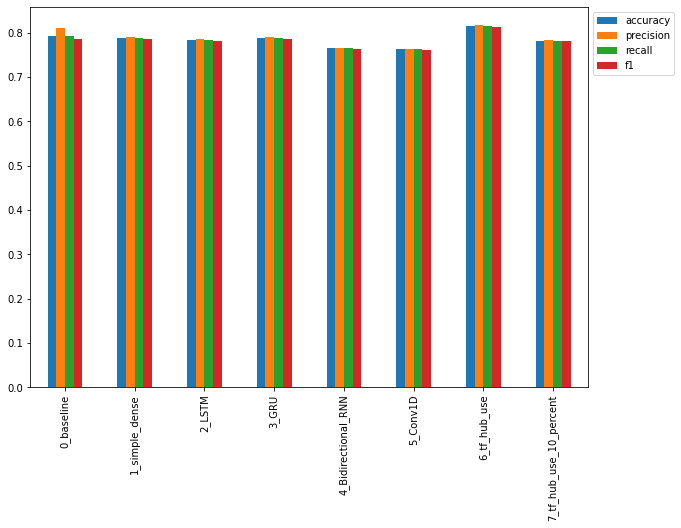

In [ ]:
# Plot and compare all of other metrics
all_model_results.plot(kind="bar", figsize=(10,7)).legend(bbox_to_anchor=(1.0,1.0))

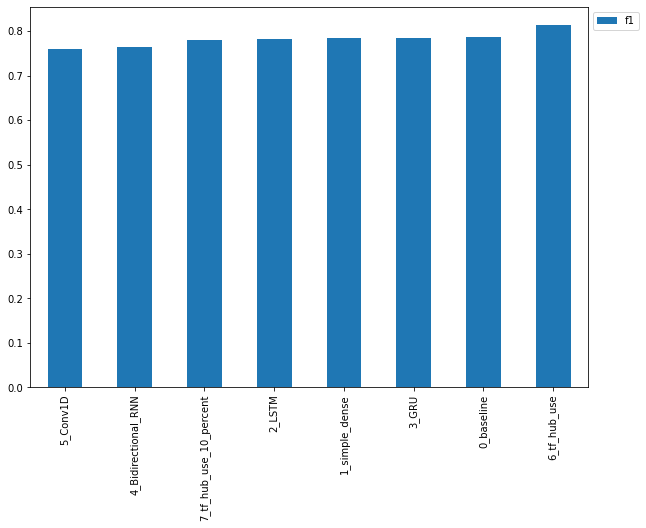

In [ ]:
# Sort model results by f1-score
all_model_results.sort_values(["f1"], ascending=True)["f1"].plot(kind="bar", figsize=(10,7)).legend(bbox_to_anchor=(1.,1.))

In [ ]:
## Uploading our model training logs to TensorBoard.dev
!pip install -U tensorboard

     |████████████████████████████████| 5.6 MB 8.1 MB/s 
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.5.0
    Uninstalling tensorboard-2.5.0:
      Successfully uninstalled tensorboard-2.5.0


In [ ]:
# !tensorboard dev upload --logdir model_logs \
#     --name "Experiment in NLP" \
#     --description "Simple comparison of several models"

2021-08-16 04:22:10.415667: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0

***** TensorBoard Uploader *****

This will upload your TensorBoard logs to https://tensorboard.dev/ from
the following directory:

model_logs

This TensorBoard will be visible to everyone. Do not upload sensitive
data.

Your use of this service is subject to Google's Terms of Service
<https://policies.google.com/terms> and Privacy Policy
<https://policies.google.com/privacy>, and TensorBoard.dev's Terms of Service
<https://tensorboard.dev/policy/terms/>.

This notice will not be shown again while you are logged into the uploader.
To log out, run `tensorboard dev auth revoke`.

Continue? (yes/NO) y

Please visit this URL to authorize this application: https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=373649185512-8v619h5kft38l4456nm2dj4ubeqsrvh6.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&

## Saving and loading a trained model

* HDF5 Format
* The `SaveModel` format

In [ ]:
model_6_extra.save("/content/drive/MyDrive/Tensorflow Certificate Exam/Weights/08_NLP_model_6.h5")

In [ ]:
import tensorflow_hub as hub
# Load model with custom Hub layers (required in HDF5 format)
model_6_extra_loaded = tf.keras.models.load_model("/content/drive/MyDrive/Tensorflow Certificate Exam/Weights/08_NLP_model_6.h5",
                                                  custom_objects={"KerasLayer":hub.KerasLayer})

In [ ]:
model_6_extra_loaded.evaluate(val_sentences, val_labels)

24/24 [==============================] - 1s 9ms/step - loss: 0.4305 - accuracy: 0.8150


[0.4304679334163666, 0.8149606585502625]

In [ ]:
model_6_results_extra

{'accuracy': 81.49606299212599,
 'f1': 0.8134357776936025,
 'precision': 0.8172549323109193,
 'recall': 0.8149606299212598}

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Now, let's save to the `SavedModel` format

In [ ]:
model_6_extra.save("/content/drive/MyDrive/Tensorflow Certificate Exam/Weights/08_NLP_model_6")

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Tensorflow Certificate Exam/Weights/08_NLP_model_6/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Tensorflow Certificate Exam/Weights/08_NLP_model_6/assets


In [ ]:
# Load in a model from SavedModel format
model_6_extra_loaded_savedmodel = tf.keras.models.load_model("/content/drive/MyDrive/Tensorflow Certificate Exam/Weights/08_NLP_model_6")

In [ ]:
model_6_extra_loaded_savedmodel.evaluate(val_sentences, val_labels)

24/24 [==============================] - 1s 10ms/step - loss: 0.4305 - accuracy: 0.8150


[0.4304679334163666, 0.8149606585502625]

## Finding the most wrong examples

* If our best model still isn't perfect, what example is it getting wrong?
* And of these wrong examples which ones is getting **most** wrong? 


In [ ]:
model_6_pretrained_pred_prob = model_6_extra_loaded.predict(val_sentences)
model_6_pretrained_pred = tf.squeeze(tf.round(model_6_pretrained_pred_prob))

In [ ]:
# model_6_pretrained_pred_prob

In [ ]:
# Create DataFrame with validation sentences and best performing model predictions
val_df = pd.DataFrame({
    "text":val_sentences,
    "target":val_labels,
    "pred": model_6_pretrained_pred,
    "pred_prob": tf.squeeze(model_6_pretrained_pred_prob)
})
val_df

,text,target,pred,pred_prob
0,DFR EP016 Monthly Meltdown - On Dnbheaven 2015...,0,0.0,0.148855
1,FedEx no longer to transport bioterror germs i...,0,1.0,0.745863
2,Gunmen kill four in El Salvador bus attack: Su...,1,1.0,0.988023
3,@camilacabello97 Internally and externally scr...,1,0.0,0.204608
4,Radiation emergency #preparedness starts with ...,1,1.0,0.735095
...,...,...,...,...
757,That's the ultimate road to destruction,0,0.0,0.107237
758,@SetZorah dad why dont you claim me that mean ...,0,0.0,0.092743
759,FedEx will no longer transport bioterror patho...,0,1.0,0.862921
760,Crack in the path where I wiped out this morni...,0,1.0,0.674188


In [ ]:
# Find the wrong predictions and sort by prediction probabilities
most_wrong = val_df[val_df["target"] != val_df["pred"]].sort_values("pred_prob", ascending=False)
most_wrong

,text,target,pred,pred_prob
31,? High Skies - Burning Buildings ? http://t.co...,0,1.0,0.914038
759,FedEx will no longer transport bioterror patho...,0,1.0,0.862921
628,@noah_anyname That's where the concentration c...,0,1.0,0.846421
393,@SonofLiberty357 all illuminated by the bright...,0,1.0,0.834189
49,@madonnamking RSPCA site multiple 7 story high...,0,1.0,0.830794
...,...,...,...,...
233,I get to smoke my shit in peace,1,0.0,0.041146
244,Reddit Will Now QuarantineÛ_ http://t.co/pkUA...,1,0.0,0.040408
411,@SoonerMagic_ I mean I'm a fan but I don't nee...,1,0.0,0.035418
38,Why are you deluged with low self-image? Take ...,1,0.0,0.035151


In [ ]:
most_wrong.head() # these are false positive

,text,target,pred,pred_prob
31,? High Skies - Burning Buildings ? http://t.co...,0,1.0,0.914038
759,FedEx will no longer transport bioterror patho...,0,1.0,0.862921
628,@noah_anyname That's where the concentration c...,0,1.0,0.846421
393,@SonofLiberty357 all illuminated by the bright...,0,1.0,0.834189
49,@madonnamking RSPCA site multiple 7 story high...,0,1.0,0.830794


In [ ]:
most_wrong.tail() # these are false negative

,text,target,pred,pred_prob
233,I get to smoke my shit in peace,1,0.0,0.041146
244,Reddit Will Now QuarantineÛ_ http://t.co/pkUA...,1,0.0,0.040408
411,@SoonerMagic_ I mean I'm a fan but I don't nee...,1,0.0,0.035418
38,Why are you deluged with low self-image? Take ...,1,0.0,0.035151
23,Ron &amp; Fez - Dave's High School Crush https...,1,0.0,0.033285


In [ ]:
# Check out the false positive 
for row in most_wrong[:10].itertuples():
  _, text, target, pred, pred_prob = row
  print(f"Target: {target}, Pred: {pred}, Prob: {pred_prob}")
  print(f"Text: \n {text}")
  print(f"----\n")

Target: 0, Pred: 1.0, Prob: 0.9140378832817078
Text: 
 ? High Skies - Burning Buildings ? http://t.co/uVq41i3Kx2 #nowplaying
----

Target: 0, Pred: 1.0, Prob: 0.8629205822944641
Text: 
 FedEx will no longer transport bioterror pathogens in wake of anthrax lab mishaps http://t.co/lHpgxc4b8J
----

Target: 0, Pred: 1.0, Prob: 0.8464211821556091
Text: 
 @noah_anyname That's where the concentration camps and mass murder come in. 
 
EVERY. FUCKING. TIME.
----

Target: 0, Pred: 1.0, Prob: 0.8341894149780273
Text: 
 @SonofLiberty357 all illuminated by the brightly burning buildings all around the town!
----

Target: 0, Pred: 1.0, Prob: 0.8307939767837524
Text: 
 @madonnamking RSPCA site multiple 7 story high rise buildings next to low density character residential in an area that floods
----

Target: 0, Pred: 1.0, Prob: 0.8067635297775269
Text: 
 Ashes 2015: AustraliaÛªs collapse at Trent Bridge among worst in history: England bundled out Australia for 60 ... http://t.co/t5TrhjUAU0
----

Targ

In [ ]:
for row in most_wrong[-10:].itertuples(): # false negative
  _, text, target, pred, pred_prob = row
  print(f"Target: {target}, Pred: {pred}, Prob: {pred_prob}")
  print(f"Text: \n {text}")
  print(f"----\n")

Target: 1, Pred: 0.0, Prob: 0.056611623615026474
Text: 
 Lucas Duda is Ghost Rider. Not the Nic Cage version but an actual 'engulfed in flames' badass. #Mets
----

Target: 1, Pred: 0.0, Prob: 0.054985757917165756
Text: 
 You can never escape me. Bullets don't harm me. Nothing harms me. But I know pain. I know pain. Sometimes I share it. With someone like you.
----

Target: 1, Pred: 0.0, Prob: 0.05486581474542618
Text: 
 @BoyInAHorsemask its a panda trapped in a dogs body
----

Target: 1, Pred: 0.0, Prob: 0.0540243498980999
Text: 
 going to redo my nails and watch behind the scenes of desolation of smaug ayyy
----

Target: 1, Pred: 0.0, Prob: 0.05362154543399811
Text: 
 @willienelson We need help! Horses will die!Please RT &amp; sign petition!Take a stand &amp; be a voice for them! #gilbert23 https://t.co/e8dl1lNCVu
----

Target: 1, Pred: 0.0, Prob: 0.04114611819386482
Text: 
 I get to smoke my shit in peace
----

Target: 1, Pred: 0.0, Prob: 0.04040781036019325
Text: 
 Reddit Will Now Q

## Making predictions on the test dataset

In [ ]:
# Making prediction on the test dataset and visualizing them 
test_sentences = test_df["text"].to_list()
test_sentences[:10]

['Just happened a terrible car crash',
 'Heard about #earthquake is different cities, stay safe everyone.',
 'there is a forest fire at spot pond, geese are fleeing across the street, I cannot save them all',
 'Apocalypse lighting. #Spokane #wildfires',
 'Typhoon Soudelor kills 28 in China and Taiwan',
 "We're shaking...It's an earthquake",
 "They'd probably still show more life than Arsenal did yesterday, eh? EH?",
 'Hey! How are you?',
 'What a nice hat?',
 'Fuck off!']

In [ ]:
import random

def predict_and_print_text(model, test_sentences):
  """
  Predict text and then print text + predict

  Args:
    model (tensorflow model)
    test_sentences (list string)
  """
  test_samples = random.sample(test_sentences, 10)
  # test_samples
  for text in test_samples:
    pred_prob = tf.squeeze(model_6_extra_loaded.predict([text]))
    pred = tf.round(pred_prob)
    print(f"Pred: {pred}, Prob: {pred_prob}")
    print(f"Text: \n {text}")
    print(f"----\n")

In [ ]:
predict_and_print_text(model_6_extra_loaded, test_sentences)

Pred: 1.0, Prob: 0.9805139899253845
Text: 
 Sinjar Massacre Yazidis Blast Lack of Action Over Hostages http://t.co/fdU8aCnC2W #denver #billings #rapidcity #seattle #cheyenne #lasvegas
----

Pred: 0.0, Prob: 0.06551807373762131
Text: 
 @yakubOObs think he deactivated because his notifications are aids after tesco wrecked him lol
----

Pred: 1.0, Prob: 0.6423541307449341
Text: 
 I think Tsunami has hit the wall. Dang... #STLCards
----

Pred: 0.0, Prob: 0.11585905402898788
Text: 
 @RaynbowAffair Editor In Chief @DiamondKesawn Releases Issue #7 http://t.co/fa0Jt1Yqru of #RAmag. #Fashion #Models and #Mayhem
----

Pred: 0.0, Prob: 0.057773247361183167
Text: 
 Ross better not be dead! #Emmerdale
----

Pred: 1.0, Prob: 0.6184669733047485
Text: 
 12000 Nigerian refugees repatriated from Cameroon http://t.co/LeLYa0vDOg read /////
----

Pred: 0.0, Prob: 0.25383496284484863
Text: 
 When you realize you could have been electrocuted last night because you grabbed this in the dark.  How??? http://t.c

## The Speed/Score tradeoff